In [57]:
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col, year, expr, rank, when, desc
from pyspark.sql.functions import year, month, expr

import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.window import Window


In [2]:
spark = SparkSession.builder \
    .appName("Sales Analysis") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/12 16:17:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/12 16:17:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
spark_df = spark.read.csv('data/Coffee Shop Sales.csv', header=True, inferSchema=True)

In [9]:
# Calculate total sales count and amount
product_sales = spark_df.groupBy('product_type').agg(
    sum('transaction_qty').alias('total_sales_count'),
    sum(expr('transaction_qty * unit_price')).alias('total_sales_amount')
)

# Convert total sales amount to integer
product_sales = product_sales.withColumn('total_sales_amount', col('total_sales_amount').cast('integer'))

product_sales = product_sales.orderBy(col('total_sales_amount').desc())

product_sales.show()

+--------------------+-----------------+------------------+
|        product_type|total_sales_count|total_sales_amount|
+--------------------+-----------------+------------------+
|    Barista Espresso|            24943|             91406|
|     Brewed Chai tea|            26250|             77081|
|       Hot chocolate|            17457|             72416|
|Gourmet brewed co...|            25973|             70034|
|    Brewed Black tea|            17462|             47932|
|   Brewed herbal tea|            17328|             47539|
|Premium brewed co...|            12431|             38781|
|Organic brewed co...|            13012|             37746|
|               Scone|            10465|             36866|
|         Drip coffee|            12891|             31984|
|              Pastry|             6961|             25655|
|    Brewed Green tea|             8697|             23852|
|            Biscotti|             5788|             19793|
|       Premium Beans|              406|

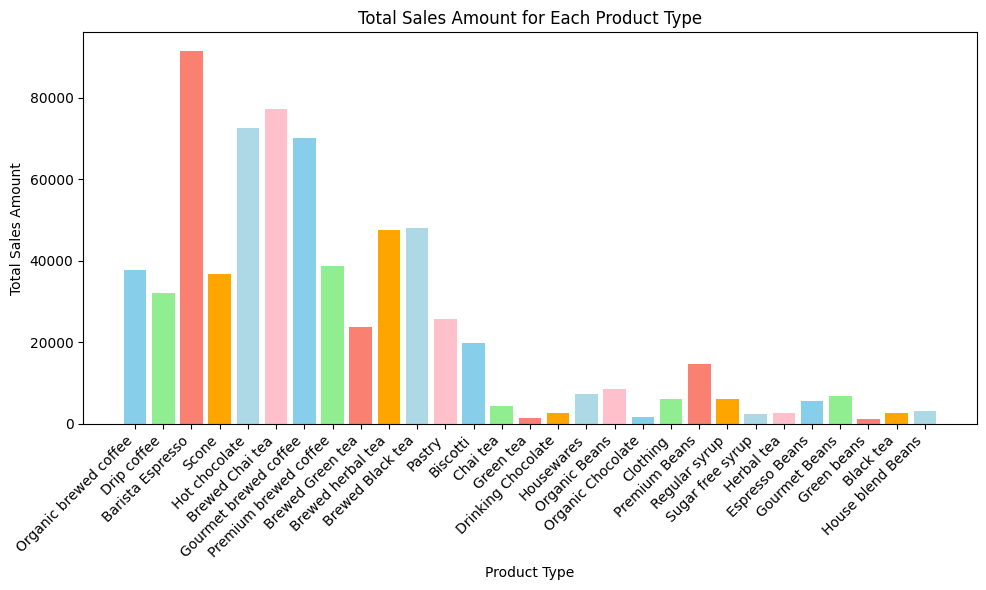

In [61]:
product_sales_pd = product_sales.toPandas()

colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'lightblue', 'pink']

plt.figure(figsize=(10, 6))
plt.bar(product_sales_pd['product_type'], product_sales_pd['total_sales_amount'], color=colors)
plt.xlabel('Product Type')
plt.ylabel('Total Sales Amount')
plt.title('Total Sales Amount for Each Product Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:
location_sales = spark_df.groupBy('store_location').agg(
    sum('transaction_qty').alias('total_sales_count'),
    sum('Total_Bill').alias('total_sales_amount')
)
location_sales.show()

+---------------+-----------------+------------------+
| store_location|total_sales_count|total_sales_amount|
+---------------+-----------------+------------------+
|Lower Manhattan|            71742|230057.24999999156|
| Hell's Kitchen|            71737|236511.16999999413|
|        Astoria|            70991|232243.90999999508|
+---------------+-----------------+------------------+



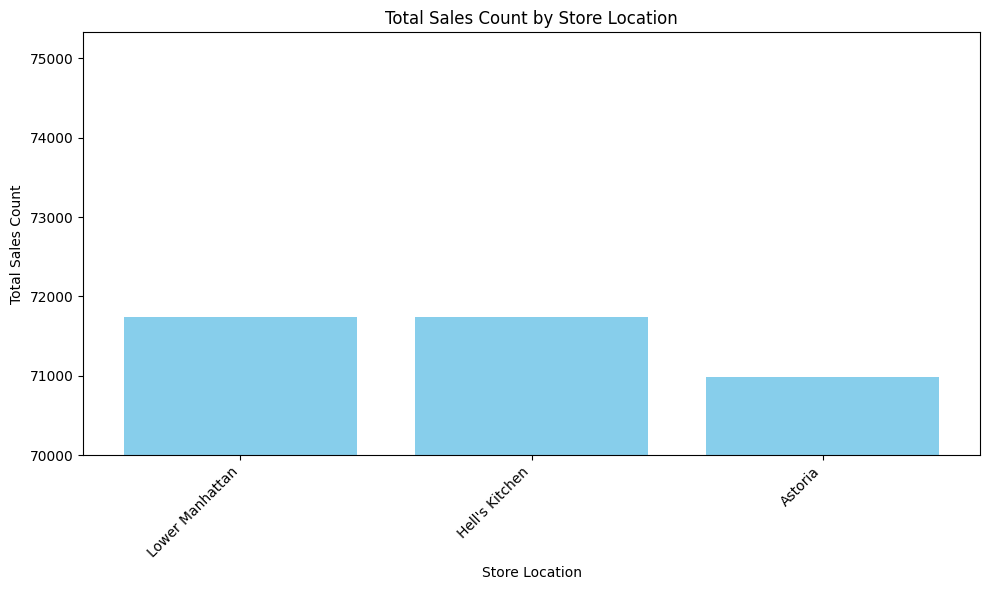

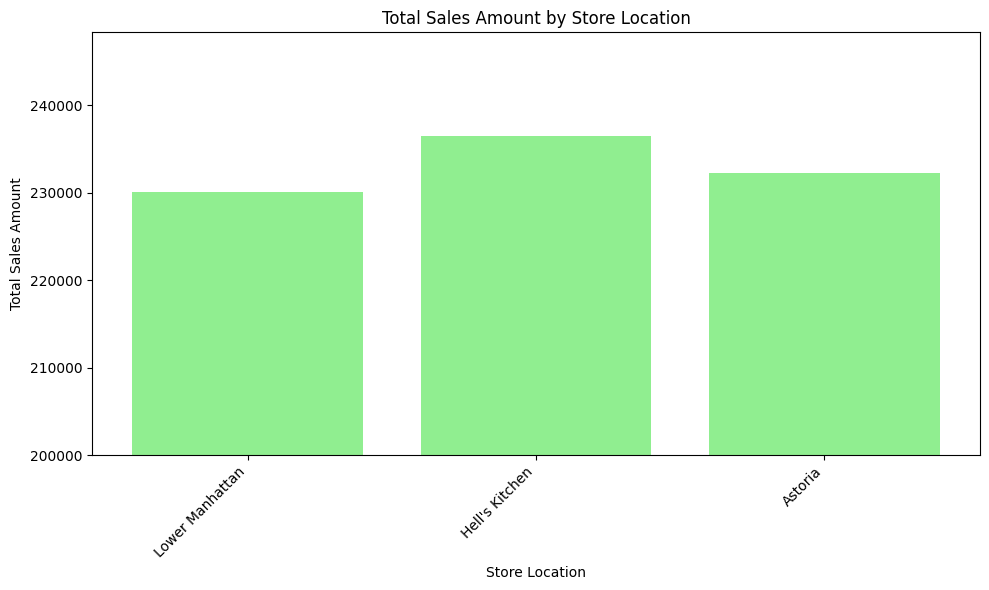

In [34]:
location_sales_pd = location_sales.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(location_sales_pd['store_location'], location_sales_pd['total_sales_count'], color='skyblue')
plt.xlabel('Store Location')
plt.ylabel('Total Sales Count')
plt.title('Total Sales Count by Store Location')
plt.xticks(rotation=45, ha='right')

# Set y-axis limits for total sales count plot
plt.gca().set_ylim(bottom=70000)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(location_sales_pd['store_location'], location_sales_pd['total_sales_amount'], color='lightgreen')
plt.xlabel('Store Location')
plt.ylabel('Total Sales Amount')
plt.title('Total Sales Amount by Store Location')
plt.xticks(rotation=45, ha='right')

# Set y-axis limits for total sales amount plot
plt.gca().set_ylim(bottom=200000)

plt.tight_layout()
plt.show()

In [58]:
# Filter coffee sales and group by size
coffee_sales = spark_df.filter(spark_df.product_category == 'Coffee').groupBy('Size').agg(
    sum('transaction_qty').alias('total_sales_count')
)
coffee_sales.show()

+-----------+-----------------+
|       Size|total_sales_count|
+-----------+-----------------+
|Not Defined|            16295|
|    Regular|            26250|
|      Large|            25282|
|      Small|            21423|
+-----------+-----------------+



In [59]:
coffee_sales_combined = coffee_sales.withColumn('Size', when(coffee_sales['Size'] == 'Not Defined', 'Regular')
                                                .otherwise(coffee_sales['Size']))

# Group by the combined size and sum the total sales count
coffee_sales_combined = coffee_sales_combined.groupBy('Size').agg(sum('total_sales_count').alias('total_sales_count'))

coffee_sales_combined = coffee_sales_combined.orderBy(desc('total_sales_count'))

# Show the combined coffee sales
coffee_sales_combined.show()

+-------+-----------------+
|   Size|total_sales_count|
+-------+-----------------+
|Regular|            42545|
|  Large|            25282|
|  Small|            21423|
+-------+-----------------+



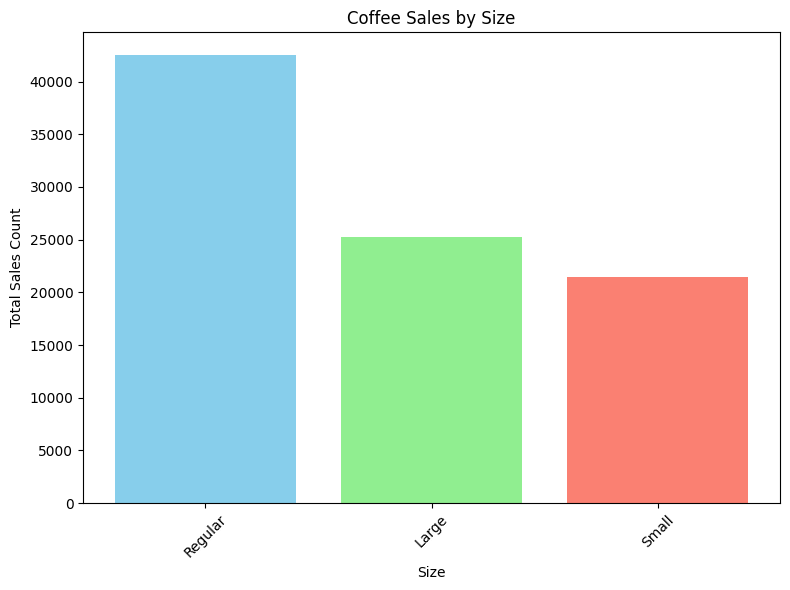

In [62]:
coffee_sales_combined_pd = coffee_sales_combined.toPandas()

# Define colors for the bars
colors = ['skyblue', 'lightgreen', 'salmon', 'orange']  # Add more colors if needed

# Plot the combined coffee sales in descending order with different colors for each bar
plt.figure(figsize=(8, 6))
plt.bar(coffee_sales_combined_pd['Size'], coffee_sales_combined_pd['total_sales_count'], color=colors)
plt.xlabel('Size')
plt.ylabel('Total Sales Count')
plt.title('Coffee Sales by Size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Extract hour from transaction_time
spark_df = spark_df.withColumn('hour', F.hour(F.col('transaction_time')))

hourly_transactions = spark_df.groupBy('hour').count()

hourly_transactions_desc = hourly_transactions.orderBy(hourly_transactions['count'].desc())

# Show the results
hourly_transactions_desc.show()

+----+-----+
|hour|count|
+----+-----+
|  10|18545|
|   9|17764|
|   8|17654|
|   7|13428|
|  11| 9766|
|  16| 9093|
|  15| 8979|
|  14| 8933|
|  17| 8745|
|  13| 8714|
|  12| 8708|
|  18| 7498|
|  19| 6092|
|   6| 4594|
|  20|  603|
+----+-----+



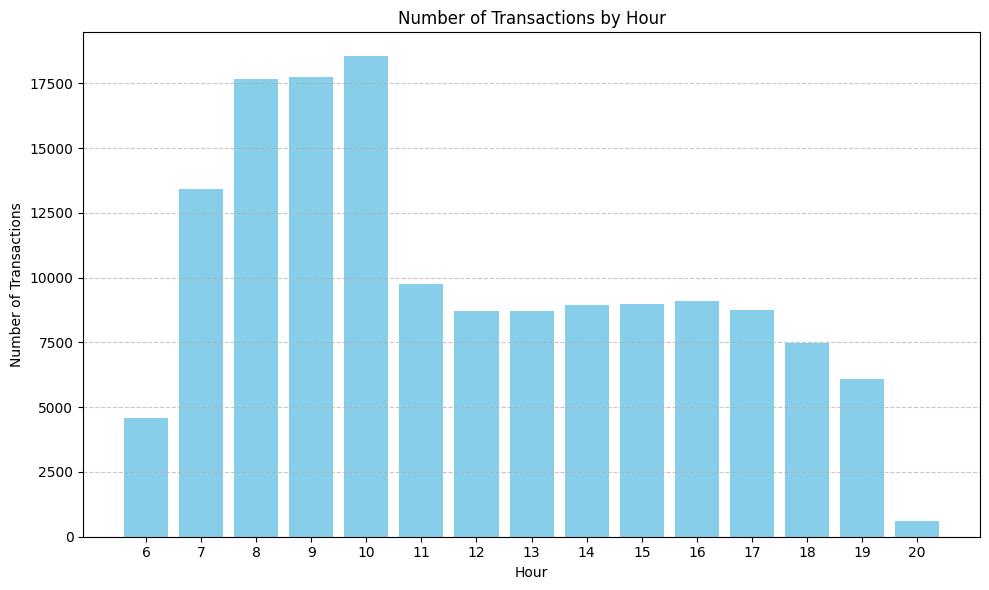

In [67]:
# Convert PySpark DataFrame to Pandas DataFrame
hourly_transactions_pd = hourly_transactions_desc.toPandas()

# Plot the count of transactions by hour
plt.figure(figsize=(10, 6))
plt.bar(hourly_transactions_pd['hour'], hourly_transactions_pd['count'], color='skyblue')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Hour')
plt.xticks(hourly_transactions_pd['hour'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()